<a href="https://colab.research.google.com/github/ktoprakucar/fine-tuning-turkish-bert-model/blob/master/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

koda geçmeden önce, koddaki BERT ile ilgili olan kısımları https://mccormickml.com/2019/07/22/BERT-fine-tuning/ linkindeki kodlardan yararlanarak oluşturduğumu belirtmek isterim

In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


In [3]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv(data_path + 'turkish_text_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [6]:
df.sample(10)

,category,text
4376,teknoloji,kırık iphone kabusu çabuk tükenen bataryaları...
49,siyaset,kamut denetçileri eski ak_partili çıktı yargı...
2993,saglik,iki uzvunu kaybetti bir dönem hülya_koçyiğit ...
4190,spor, çankaya belediye hak ettiği bir galibiyet a...
141,siyaset,fidan yasası yüksek_mahkeme de mit_müsteşarı_...
4209,teknoloji,apple iphone isim hakkını kaybetti apple raki...
3562,spor,ukraynalı golcü türkiye yi istiyor sezon başı...
4705,teknoloji,gangnam_style youtube u mest etti güney_korel...
740,dunya,marihuana obama dan daha çok oy aldı başkanlı...
1608,ekonomi,toyota türkiye den 12 bin aracını geri çağırı...


In [7]:
df.groupby('category').size()

category
dunya         700
ekonomi       700
kultur        700
saglik        700
siyaset       700
spor          700
teknoloji     700
dtype: int64

In [0]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

In [0]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [0]:
sentences = df.text.values

In [0]:
max_len = 250

In [0]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [13]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  3920
Test:  821


In [0]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

In [15]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Original:   şehitlere saygısızlık işinden etti abd  de şehitlikte çektirdiği uygunsuz fotoğrafını facebook  ta yayınlayan lindsey_stone için  lindsey  i kovun  başlıklı bir sayfa açıldı binlerce kişinin sayfayı beğenmesinin ardından stone yardım derneğindeki işinden kovuldu abd  nin massachusetts eyaletinin cape cod koyunda yaşayan ve life adlı yardım derneğinde çalışan lindsey_stone ülkenin en önemli şehitliklerinden biri olan arlington  da bir askerin mezarı başında çektirdiği fotoğrafını facebook sayfasında yayınladı internette en çok paylaşılanlar arasına giren uygunuz fotoğraf kimliği belirsiz bir kişi tarafından açılan  lindsey_stone  u kovun  sayfasının da kapak karesi oldu çalıştığı şirket binlerce kişi tarafından beğenilen sayfanın yayınlanmasının ardından stone  u kovduğunu duyurdu engelli yetişkinler yararına çalışan dernek görevlisi 30 yaşındaki stone medyada geniş yer bulan fotoğraflarını iş arkadaşı jamie schuh ile birlikte çekti daily_mail gazetesinde yer alan

In [0]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [0]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [0]:
number_of_categories = len(df['encoded_categories'].unique())

In [19]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [0]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of    123.    Elapsed: 0:00:08.
Batch    20  of    123.    Elapsed: 0:00:15.
Batch    30  of    123.    Elapsed: 0:00:23.
Batch    40  of    123.    Elapsed: 0:00:31.
Batch    50  of    123.    Elapsed: 0:00:38.
Batch    60  of    123.    Elapsed: 0:00:46.
Batch    70  of    123.    Elapsed: 0:00:54.
Batch    80  of    123.    Elapsed: 0:01:01.
Batch    90  of    123.    Elapsed: 0:01:09.
Batch   100  of    123.    Elapsed: 0:01:17.
Batch   110  of    123.    Elapsed: 0:01:24.
Batch   120  of    123.    Elapsed: 0:01:32.
Average training loss: 0.53
Training epoch took: 0:01:34
======== Epoch 2 / 4 ========
Batch    10  of    123.    Elapsed: 0:00:08.
Batch    20  of    123.    Elapsed: 0:00:15.
Batch    30  of    123.    Elapsed: 0:00:23.
Batch    40  of    123.    Elapsed: 0:00:31.
Batch    50  of    123.    Elapsed: 0:00:38.
Batch    60  of    123.    Elapsed: 0:00:46.
Batch    70  of    123.    Elapsed: 0:00:54.
Batch    80  of    123.    E

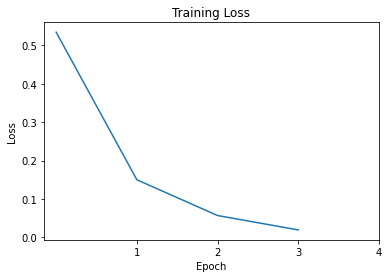

In [23]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [0]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [25]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [0]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [0]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

In [28]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.925512644500616
Recall:  0.9283536663275797
Precision:  0.9238983955338487


In [0]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [0]:
report = report.rename(columns={'0':'dunya',
                          '1':'ekonomi',
                          '2':'kultur',
                          '3':'saglik',
                          '4':'siyaset',
                          '5':'spor',
                          '6':'teknoloji'})

In [31]:
report

,dunya,ekonomi,kultur,saglik,siyaset,spor,teknoloji,accuracy,macro avg,weighted avg
precision,0.904412,0.918033,0.922222,0.921739,0.921875,0.982456,0.896552,0.923264,0.923898,0.923274
recall,0.924812,0.829630,0.954023,0.972477,0.880597,1.000000,0.936937,0.923264,0.928354,0.923264
f1-score,0.914498,0.871595,0.937853,0.946429,0.900763,0.991150,0.916300,0.923264,0.925513,0.922616
support,133.000000,135.000000,87.000000,109.000000,134.000000,112.000000,111.000000,0.923264,821.000000,821.000000
